asa

In [153]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import glob, json
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(style="whitegrid")#, color_codes=True)

from src.get_data import (
    get_air_locations_df, 
    get_traffic_locations_df,
    get_air_quality_df,
    get_weather_df,
    get_traffic_df
)
from src.constants import MADRID_AIR_QUALITY_ZONES
zones_stations_dict = {
    estacion : zone
    for zone,estaciones in MADRID_AIR_QUALITY_ZONES.items() 
    for estacion in estaciones
}

from src.data_matching import match_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Explore feature importance of the meteorological normalization models:

In [155]:
aq_station_datasets_names = json.load(open("../references/air_quality_data/aq_station_datasets_names.json","r"))
station_names_dict = {dataset_name:estacion_name for estacion_name,dataset_name in aq_station_datasets_names.items()}

dfs = []
paths = glob.glob("../reports/rf_model_importances/*.csv")
for csv in paths:
    df = pd.read_csv(csv)
    est_name = csv.split("aq_weather_")[-1].split("-")[0]
    df["estacion"] = station_names_dict[f"aq_weather_{est_name}"]
    dfs.append(df)
importances_df = pd.concat(dfs).reset_index(drop=True)
importances_df["zone"] = importances_df.estacion.replace(zones_stations_dict)
importances_df = importances_df.drop(
    columns=["estacion"]
).groupby(["zone","indicator","variable"]).mean().reset_index().sort_values(
    ["zone","importance"],ascending=False
)
importances_df

,zone,indicator,variable,rank,importance
178,7,o3_ug_m3,temperature,1.000000,301.625078
181,7,o3_ug_m3,u_wind_component_10m,2.333333,129.905462
176,7,o3_ug_m3,mean_sea_level_pressure,2.666667,127.190829
173,7,no2_ug_m3,u_wind_component_10m,1.666667,123.166227
170,7,no2_ug_m3,temperature,1.666667,103.395793
...,...,...,...,...,...
29,1,pm25_ug_m3,u_wind_component_10m,4.000000,6.616243
26,1,pm25_ug_m3,temperature,5.000000,6.385809
24,1,pm25_ug_m3,mean_sea_level_pressure,6.000000,4.816258
25,1,pm25_ug_m3,surface_pressure,7.000000,4.562155


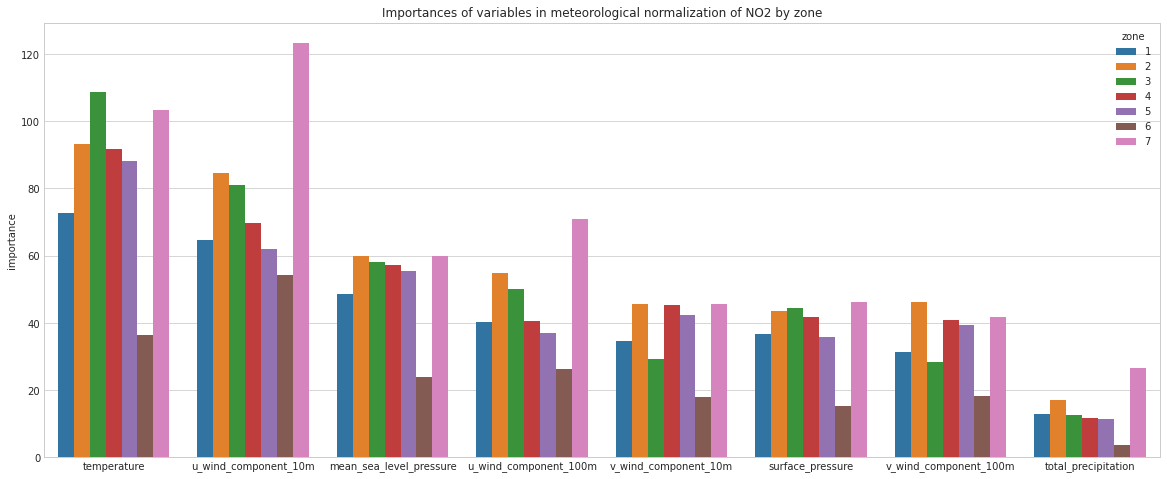

In [156]:
indicator = "no2_ug_m3"
plt.figure(figsize=(20,8))
plt.style.use("seaborn-whitegrid")

df = importances_df[importances_df.indicator==indicator]
rank_vars = df.groupby(
    "variable"
    ).mean().sort_values(
        "rank",ascending=True
    )["rank"].rank()
sns.barplot(
    data=df.assign(var_rank=df.variable.replace(rank_vars.to_dict())).sort_values("var_rank"),
    x="variable",
    y="importance",
    hue="zone",
).set(
    title=f"Importances of variables in meteorological normalization of {indicator.split('_')[0].upper()} by zone",
    xlabel="",
)
plt.savefig(f"../reports/figures/{indicator.split('_')[0]}_weather_importances.png")

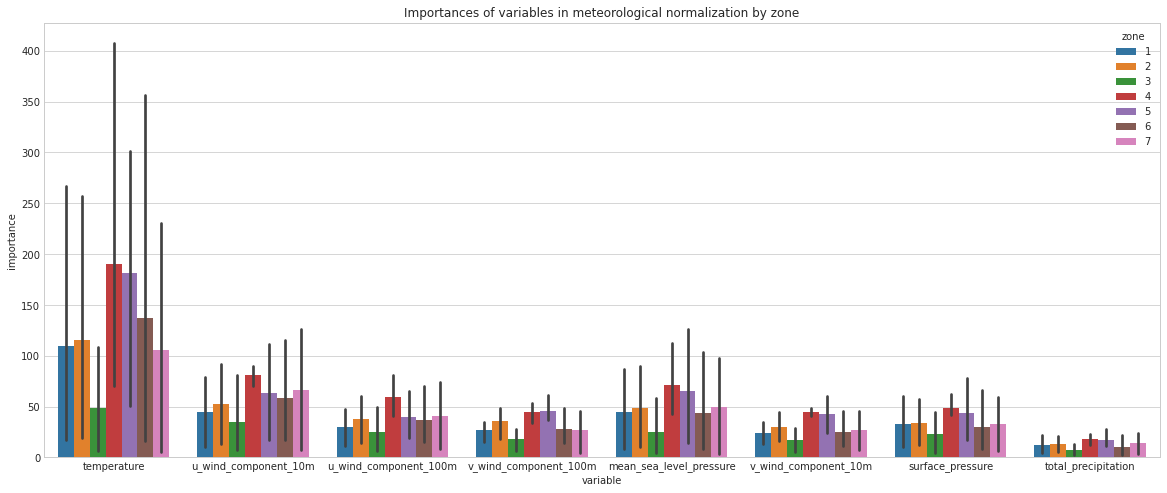

In [157]:
rank_vars = importances_df.groupby(
    "variable"
    ).mean().sort_values(
        "rank",ascending=True
    )["rank"].rank()

plt.figure(figsize=(20,8))
sns.barplot(
    data=importances_df.assign(
        var_rank=importances_df.variable.replace(rank_vars.to_dict())
    ).sort_values("var_rank"),
    x="variable",
    y="importance",
    hue="zone",
).set_title(f"Importances of variables in meteorological normalization by zone")
plt.savefig(f"../reports/figures/weather_importances_by_zone.png")

----------

<AxesSubplot:title={'center':'Madrid - Average concentrations of NO2 in 2020'}>

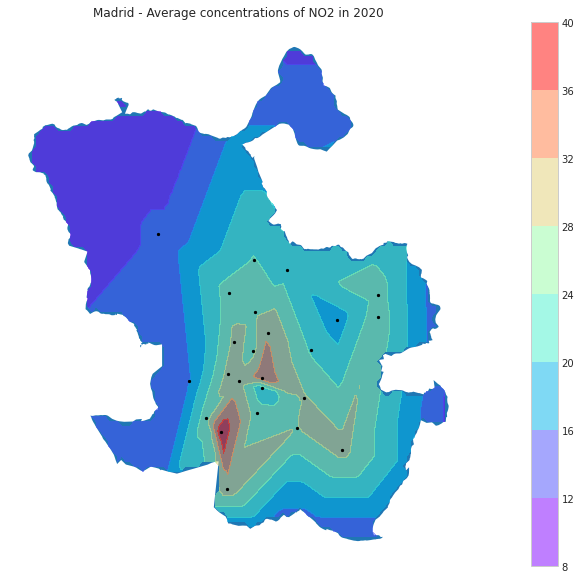

In [149]:
from src.visualization import make_countoured_map_of_concentrations
from src.get_data import (
    get_air_locations_df, 
    get_air_quality_df,
)
import matplotlib as mpl

air_locations = get_air_locations_df("../01-data").drop(columns=["zone"])
aq_data = get_air_quality_df("../01-data")
aq_data.columns = aq_data.columns.str.replace("µ","u")

indicator = "no2_ug_m3"
year = 2020
title = f"Madrid - Average concentrations of {indicator.split('_')[0].upper()} in {year}"

df_map = aq_data[aq_data.time.dt.year==year]
df_map = df_map.merge(air_locations.set_index("estacion"),on="estacion")

make_countoured_map_of_concentrations(df_map,indicator,title=title)

Plotting the difference between 2020 and 2014

In [150]:
year_recent = 2020
year_old = 2014
indicator = "no2_ug_m3"

indicator_str = indicator.split('_')[0].upper()
title_format = "Madrid - Average concentrations of " + indicator_str + " in {year}"

df_map_old = aq_data[aq_data.time.dt.year==year_old]
df_map_old = df_map_old.merge(air_locations.set_index("estacion"),on="estacion")

df_map_recent = aq_data[aq_data.time.dt.year==year_recent]
df_map_recent = df_map_recent.merge(air_locations.set_index("estacion"),on="estacion")

estaciones = pd.Index(df_map_old.estacion.unique()).intersection(df_map_recent.estacion.unique())
df_map_diff = pd.DataFrame(columns=["estacion",indicator,"latitud","longitud"])
for estacion in estaciones:
    df_old_estacion = df_map_old[df_map_old.estacion==estacion]\
        .set_index("time").resample("1D").mean().reset_index()
    df_recent_estacion = df_map_recent[df_map_recent.estacion==estacion]\
        .set_index("time").resample("1D").mean().reset_index()
    df_old_estacion = df_old_estacion[
        df_old_estacion.time.dt.strftime("%m-%d").isin(df_recent_estacion.time.dt.strftime("%m-%d"))
    ].copy()
    df_recent_estacion = df_recent_estacion[
        df_recent_estacion.time.dt.strftime("%m-%d").isin(df_old_estacion.time.dt.strftime("%m-%d"))
    ]
    df_diff_estacion = pd.DataFrame()
    df_diff_estacion[indicator] = df_recent_estacion[indicator] - df_old_estacion[indicator]
    df_diff_estacion["latitud"] = df_recent_estacion.latitud
    df_diff_estacion["longitud"] = df_recent_estacion.longitud
    df_diff_estacion["estacion"] = estacion
    df_map_diff = df_map_diff.append(df_diff_estacion)

/tmp/ipykernel_7861/3050460062.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = mpl.colorbar.ColorbarBase(ax3,cmap=cmap,norm=norm,orientation="vertical")


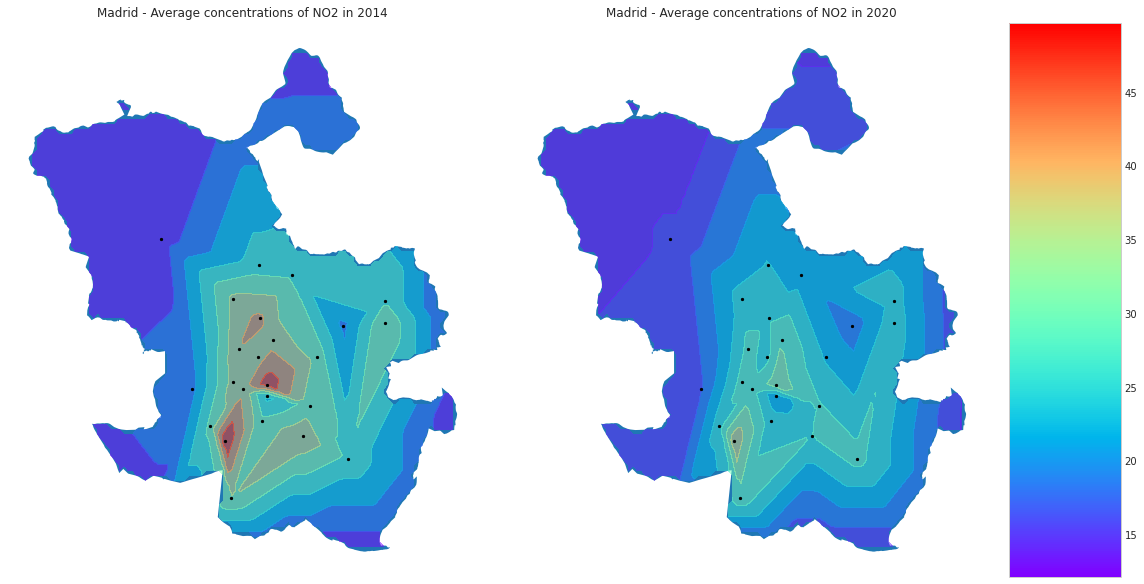

In [151]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True,figsize=(16,8))
gs = GridSpec(4, 7, figure=fig,width_ratios=[.15,.15,.15,.15,.15,.15,.1])

vmin = min(df_map_recent.groupby("estacion").mean()[indicator].min(),df_map_old.groupby("estacion").mean()[indicator].min())
vmax = max(df_map_recent.groupby("estacion").mean()[indicator].max(),df_map_old.groupby("estacion").mean()[indicator].max())

ax1 = fig.add_subplot(gs[:4, :3])
make_countoured_map_of_concentrations(
    df_map_old,indicator,
    vmin=vmin,vmax=vmax,
    title=title_format.format(year=year_old),
    ax=ax1)


ax2 = fig.add_subplot(gs[:4, 3:6])
make_countoured_map_of_concentrations(
    df_map_recent,indicator,
    vmin=vmin,vmax=vmax,
    title=title_format.format(year=year_recent),
    ax=ax2)


ax3 = fig.add_subplot(gs[:4, 6])
cmap = mpl.cm.get_cmap("rainbow")
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
cb = mpl.colorbar.ColorbarBase(ax3,cmap=cmap,norm=norm,orientation="vertical")

# fig.tight_layout()

<AxesSubplot:title={'center':'Madrid - Difference in concentrations of NO2 (2020 - 2014)'}>

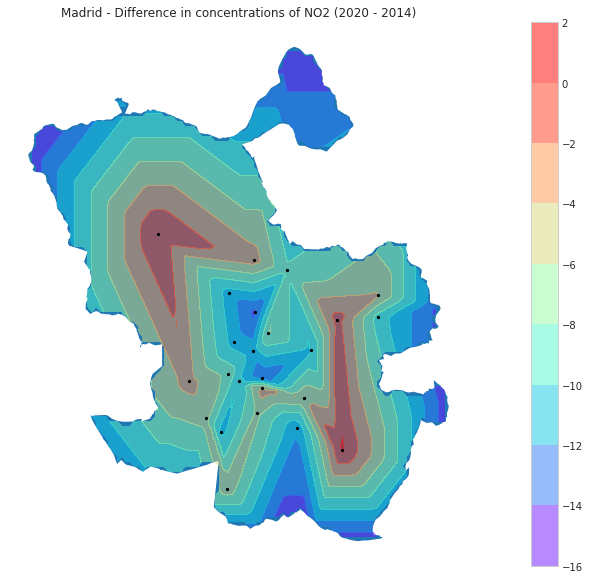

In [152]:
make_countoured_map_of_concentrations(
    df_map_diff,indicator,
    title=f"Madrid - Difference in concentrations of {indicator_str} ({year_recent} - {year_old})",
)